# **makemore** character level language model

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

### summary of the full network

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

### splitting up the dataset into training, validation and test splits

In [4]:
def build_dataset(words):
    X = []
    Y = []

    block_size = 3
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

### experiment: larger hidden layer

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [7]:
sum(p.nelement() for p in parameters)

10281

### training on the full dataset, minibatches

In [8]:
for p in parameters:
    p.requires_grad = True

### find a good initial learning rate

In [9]:
stepi = []
lossi = []
for i in range(100000):

    # mini-batch construct
    ix = torch.randint(0, X_train.shape[0], (32,))

    # forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr*p.grad
    
    stepi.append(i)
    lossi.append(loss.item())

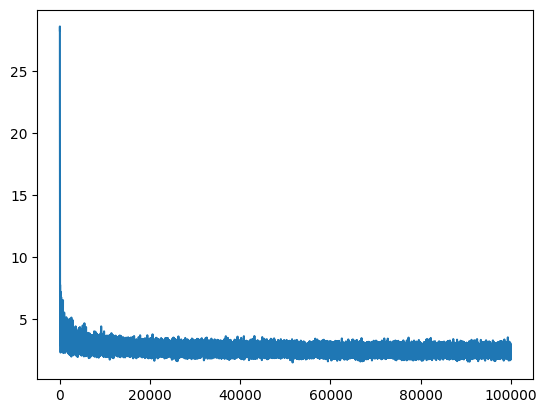

In [10]:
plt.plot(stepi, lossi);

In [11]:
emb = C[X_train]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print(f'loss = {loss.item()}')

loss = 2.385399580001831


In [12]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
print(f'loss = {loss.item()}')

loss = 2.3945794105529785


### visualizing the character embeddings

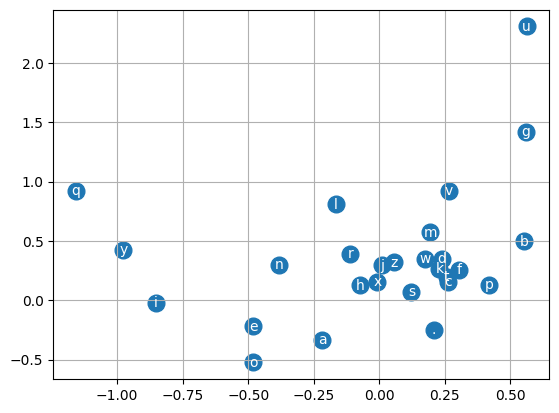

In [13]:
plt.plot(figsize=(14, 14))
plt.scatter(C[:,0].data, C[:,1].data, s=144)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('major');